## Prepare Notebook

In [41]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from sklearn import set_config
from sklearn.preprocessing import MaxAbsScaler

set_config(transform_output="pandas")


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed: int = sum(map(ord, "mmm_roas"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Data Generating Process

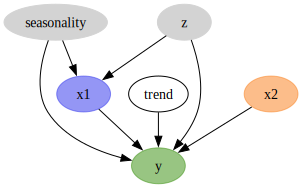

In [3]:
# https://graphviz.org/Gallery/neato/transparency.html
# https://github.com/arviz-devs/arviz/blob/main/arviz/plots/styles/arviz-darkgrid.mplstyle
g = gr.Digraph()
g.node(name="seasonality", label="seasonality", color="lightgray", style="filled")
g.node(name="trend", label="trend")
g.node(name="z", label="z", color="lightgray", style="filled")
g.node(name="x1", label="x1", color="#2a2eec80", style="filled")
g.node(name="x2", label="x2", color="#fa7c1780", style="filled")
g.node(name="y", label="y", color="#328c0680", style="filled")
g.edge(tail_name="seasonality", head_name="x1")
g.edge(tail_name="z", head_name="x1")
g.edge(tail_name="x1", head_name="y")
g.edge(tail_name="seasonality", head_name="y")
g.edge(tail_name="trend", head_name="y")
g.edge(tail_name="z", head_name="y")
g.edge(tail_name="x2", head_name="y")
g  # noqa: B018

In [4]:
# date range
min_date = pd.to_datetime("2021-10-02")
max_date = pd.to_datetime("2024-03-30")

data_df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-SAT")}
)

n = data_df.shape[0]

data_df["dayofyear"] = data_df["date_week"].dt.dayofyear
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 3) - 1
data_df["cs"] = -np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.25)
data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.25)
data_df["seasonality"] = 0.3 * (data_df["cs"] + data_df["cc"])
data_df["z"] = 0.3 * rng.gamma(shape=1, scale=2 / 3, size=n)

Text(0.5, 0.98, 'Data Components')

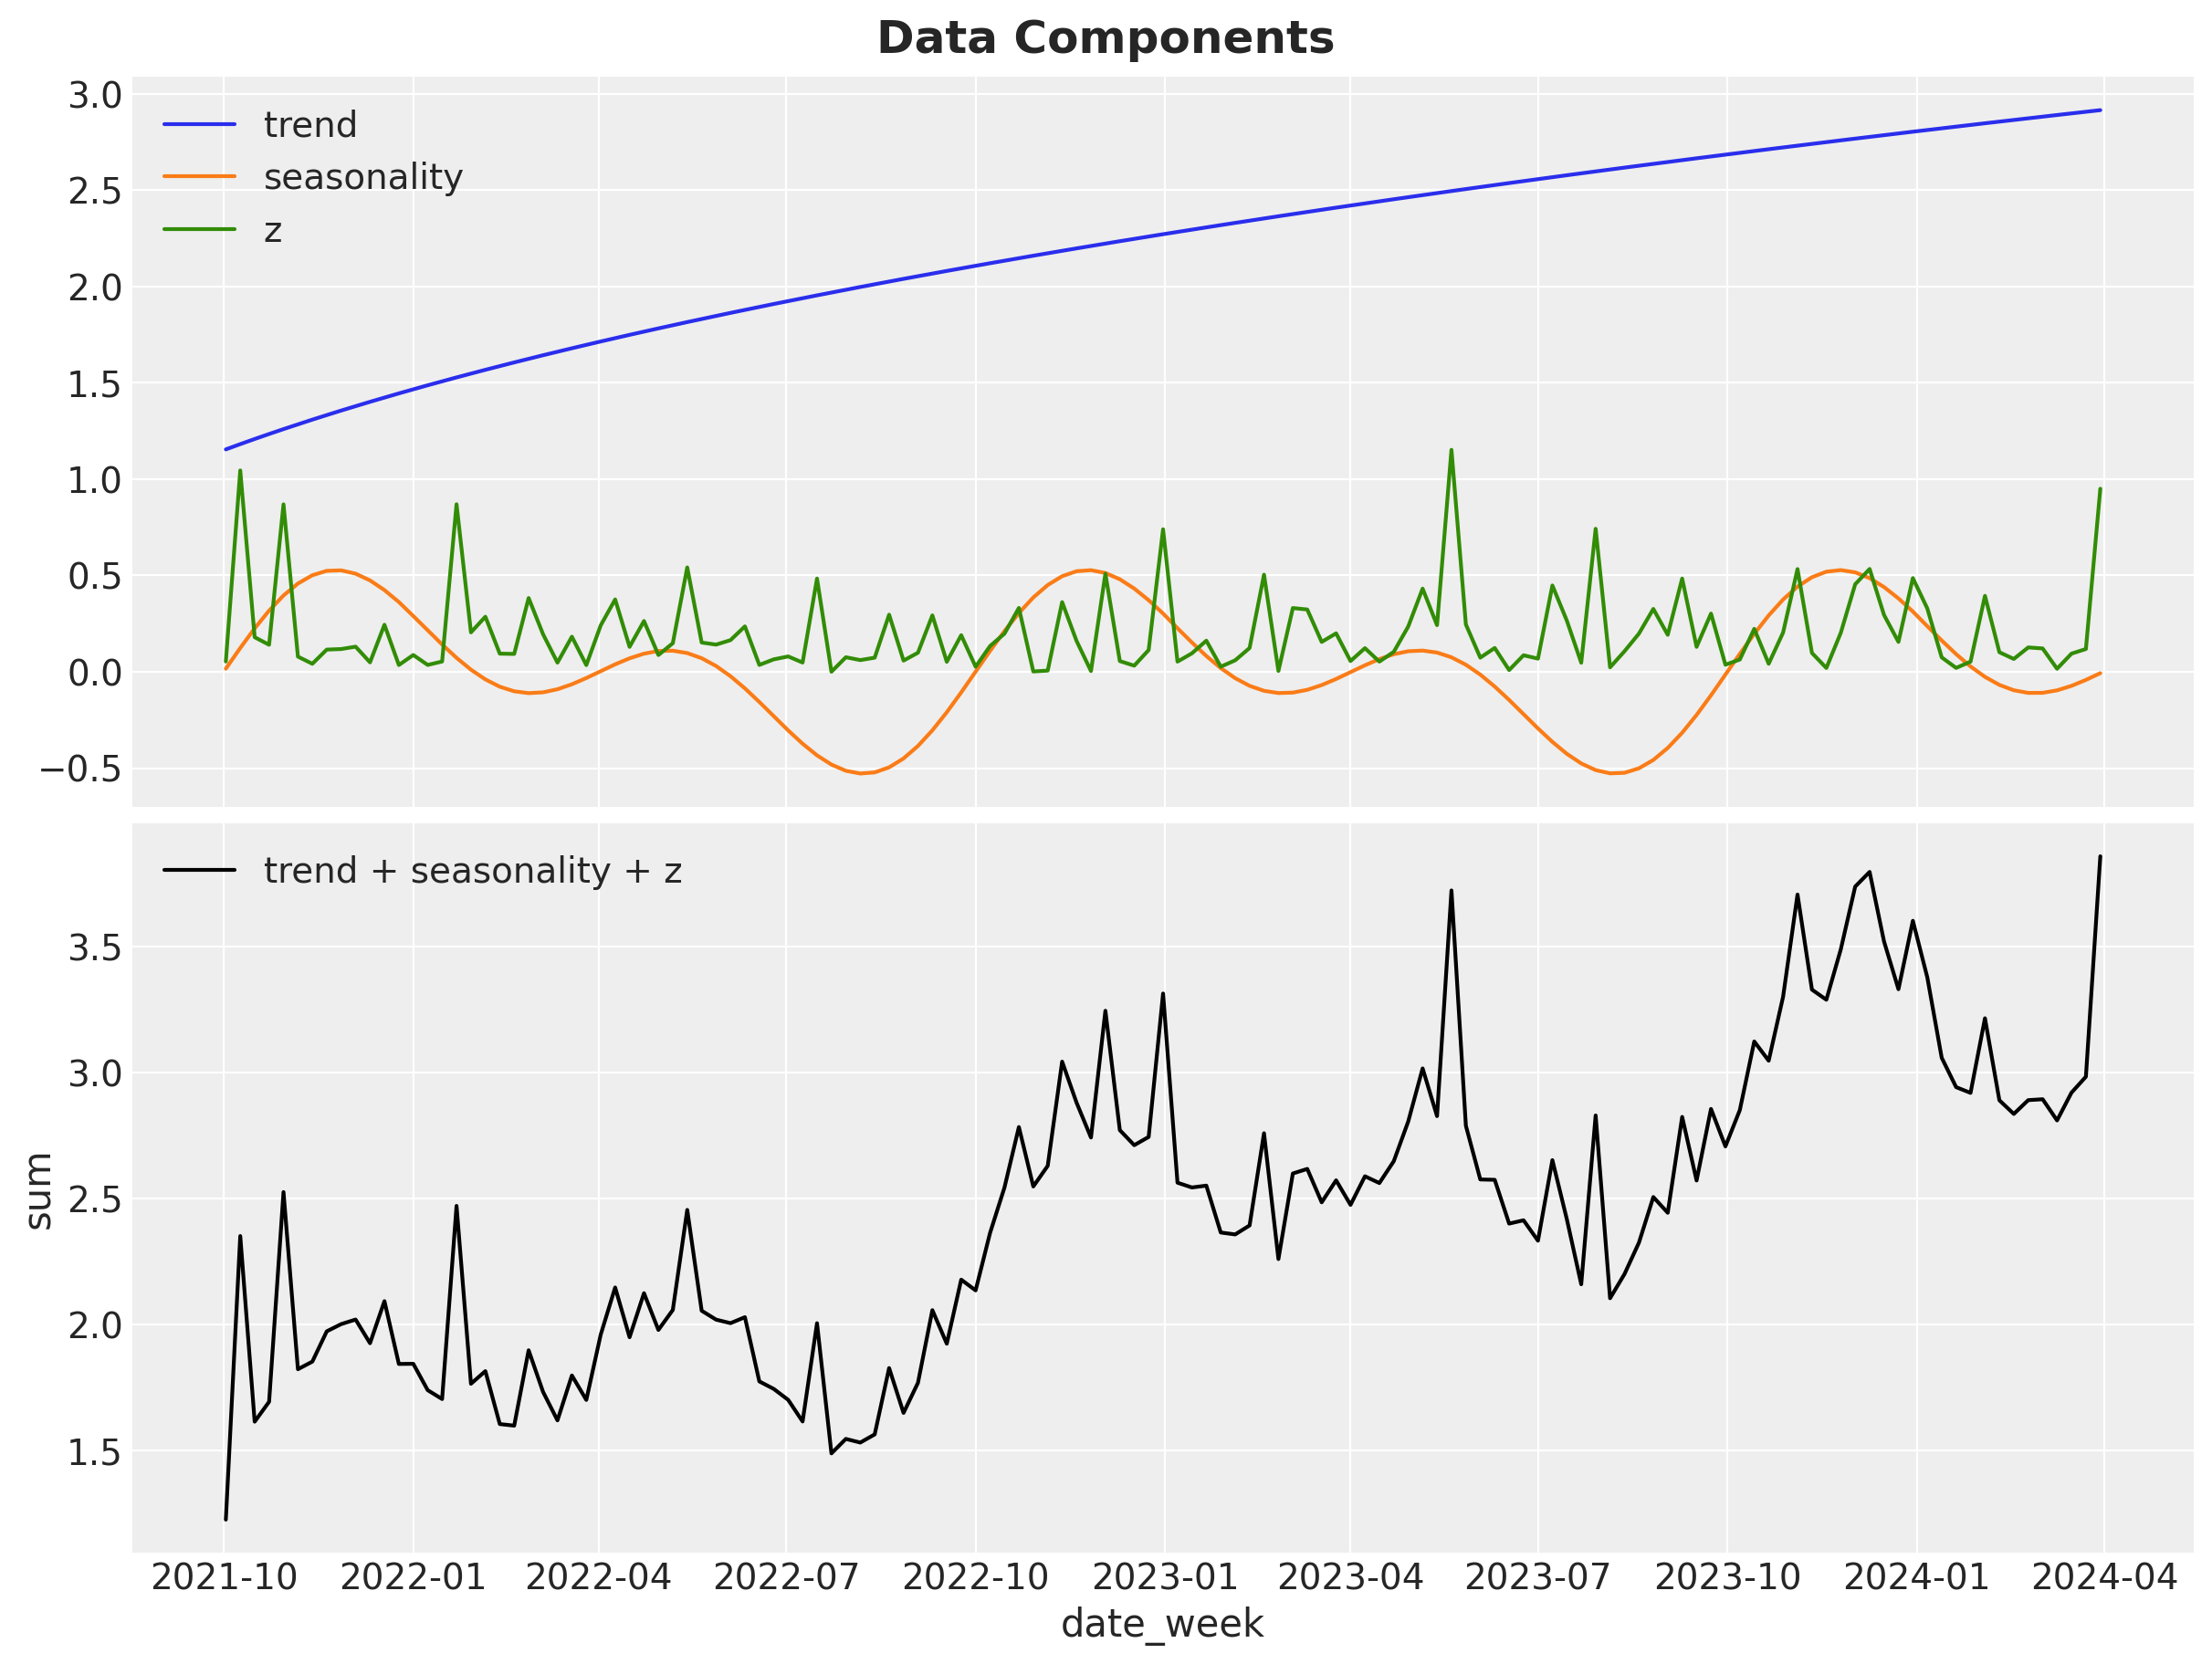

In [5]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="trend",
    color="C0",
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="seasonality",
    color="C1",
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(data=data_df, x="date_week", y="z", color="C2", label="z", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set(xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df.eval("sum = trend + seasonality + z"),
    x="date_week",
    y="sum",
    color="black",
    label="trend + seasonality + z",
    ax=ax[1],
)
ax[1].legend(loc="upper left")

fig.suptitle(t="Data Components", fontsize=18, fontweight="bold")

In [6]:
data_df["x1"] = 1.2 * (
    0.5
    + 0.4 * data_df["seasonality"]
    + 0.6 * data_df["z"]
    + 0.1 * rng.poisson(lam=1 / 2, size=n)
)

data_df["x2"] = 0.3 * rng.gamma(shape=1, scale=1, size=n)

data_df["epsilon"] = rng.normal(loc=0, scale=0.1, size=n)

Text(0.5, 0.98, 'Data Components')

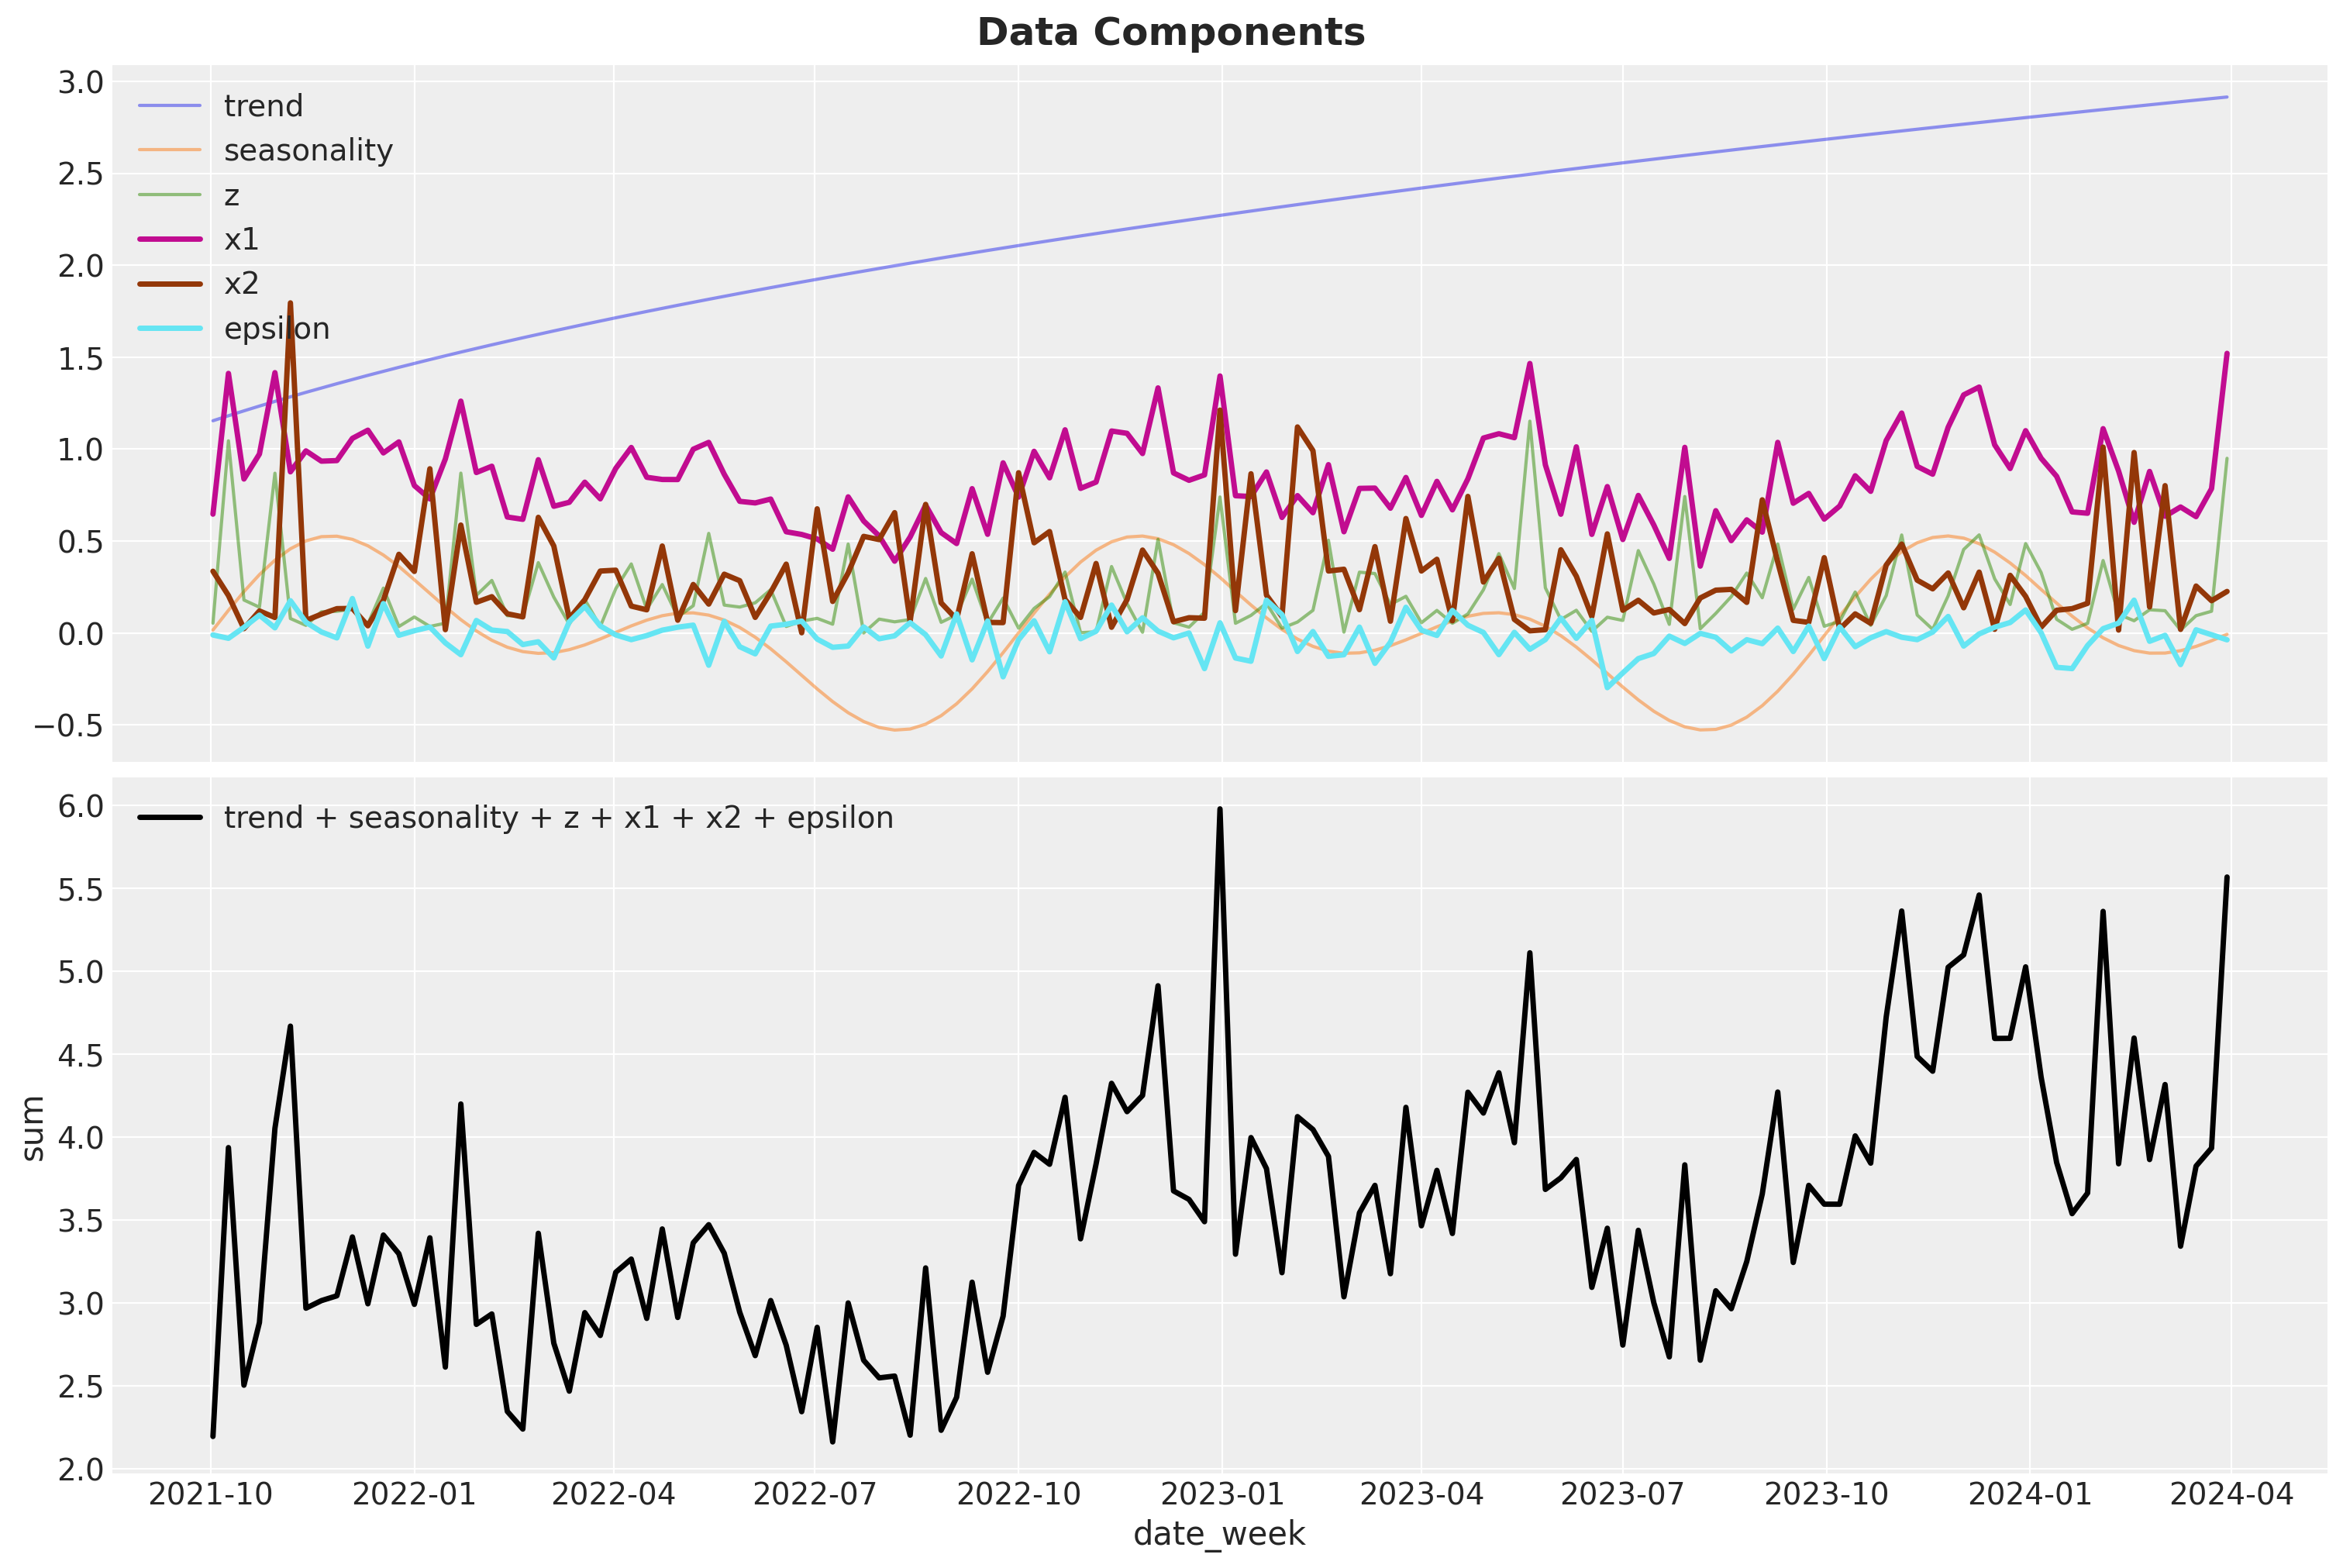

In [16]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15, 10),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="trend",
    color="C0",
    alpha=0.5,
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="seasonality",
    color="C1",
    alpha=0.5,
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(
    data=data_df, x="date_week", y="z", color="C2", alpha=0.5, label="z", ax=ax[0]
)
sns.lineplot(
    data=data_df, x="date_week", y="x1", color="C3", linewidth=2.5, label="x1", ax=ax[0]
)
sns.lineplot(
    data=data_df, x="date_week", y="x2", color="C4", linewidth=2.5, label="x2", ax=ax[0]
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="epsilon",
    color="C5",
    linewidth=2.5,
    label="epsilon",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set(xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df.eval("sum = trend + seasonality + z + x1 + x2 + epsilon"),
    x="date_week",
    y="sum",
    color="black",
    linewidth=2.5,
    label="trend + seasonality + z + x1 + x2 + epsilon",
    ax=ax[1],
)
ax[1].legend(loc="upper left")

fig.suptitle(t="Data Components", fontsize=18, fontweight="bold")

In [8]:
def geometric_adstock(x, alpha: float = 0.0, l_max: int = 8):
    """Geometric adstock transformation."""
    cycles = [pt.concatenate([pt.zeros(i), x[: x.shape[0] - i]]) for i in range(l_max)]
    x_cycle = pt.stack(cycles)
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    return pt.dot(w / pt.sum(w), x_cycle)


def logistic_saturation(x, lam: float = 0.5):
    """Logistic saturation transformation."""
    return (1 - pt.exp(-lam * x)) / (1 + pt.exp(-lam * x))

In [9]:
# apply geometric adstock transformation
alpha1: float = 0.3
alpha2: float = 0.5

data_df["x1_adstock"] = (
    geometric_adstock(x=data_df["x1"].to_numpy(), alpha=alpha1, l_max=8)
    .eval()
    .flatten()
)

data_df["x2_adstock"] = (
    geometric_adstock(x=data_df["x2"].to_numpy(), alpha=alpha2, l_max=8)
    .eval()
    .flatten()
)

Text(0.5, 0.98, 'Adstock Transformation')

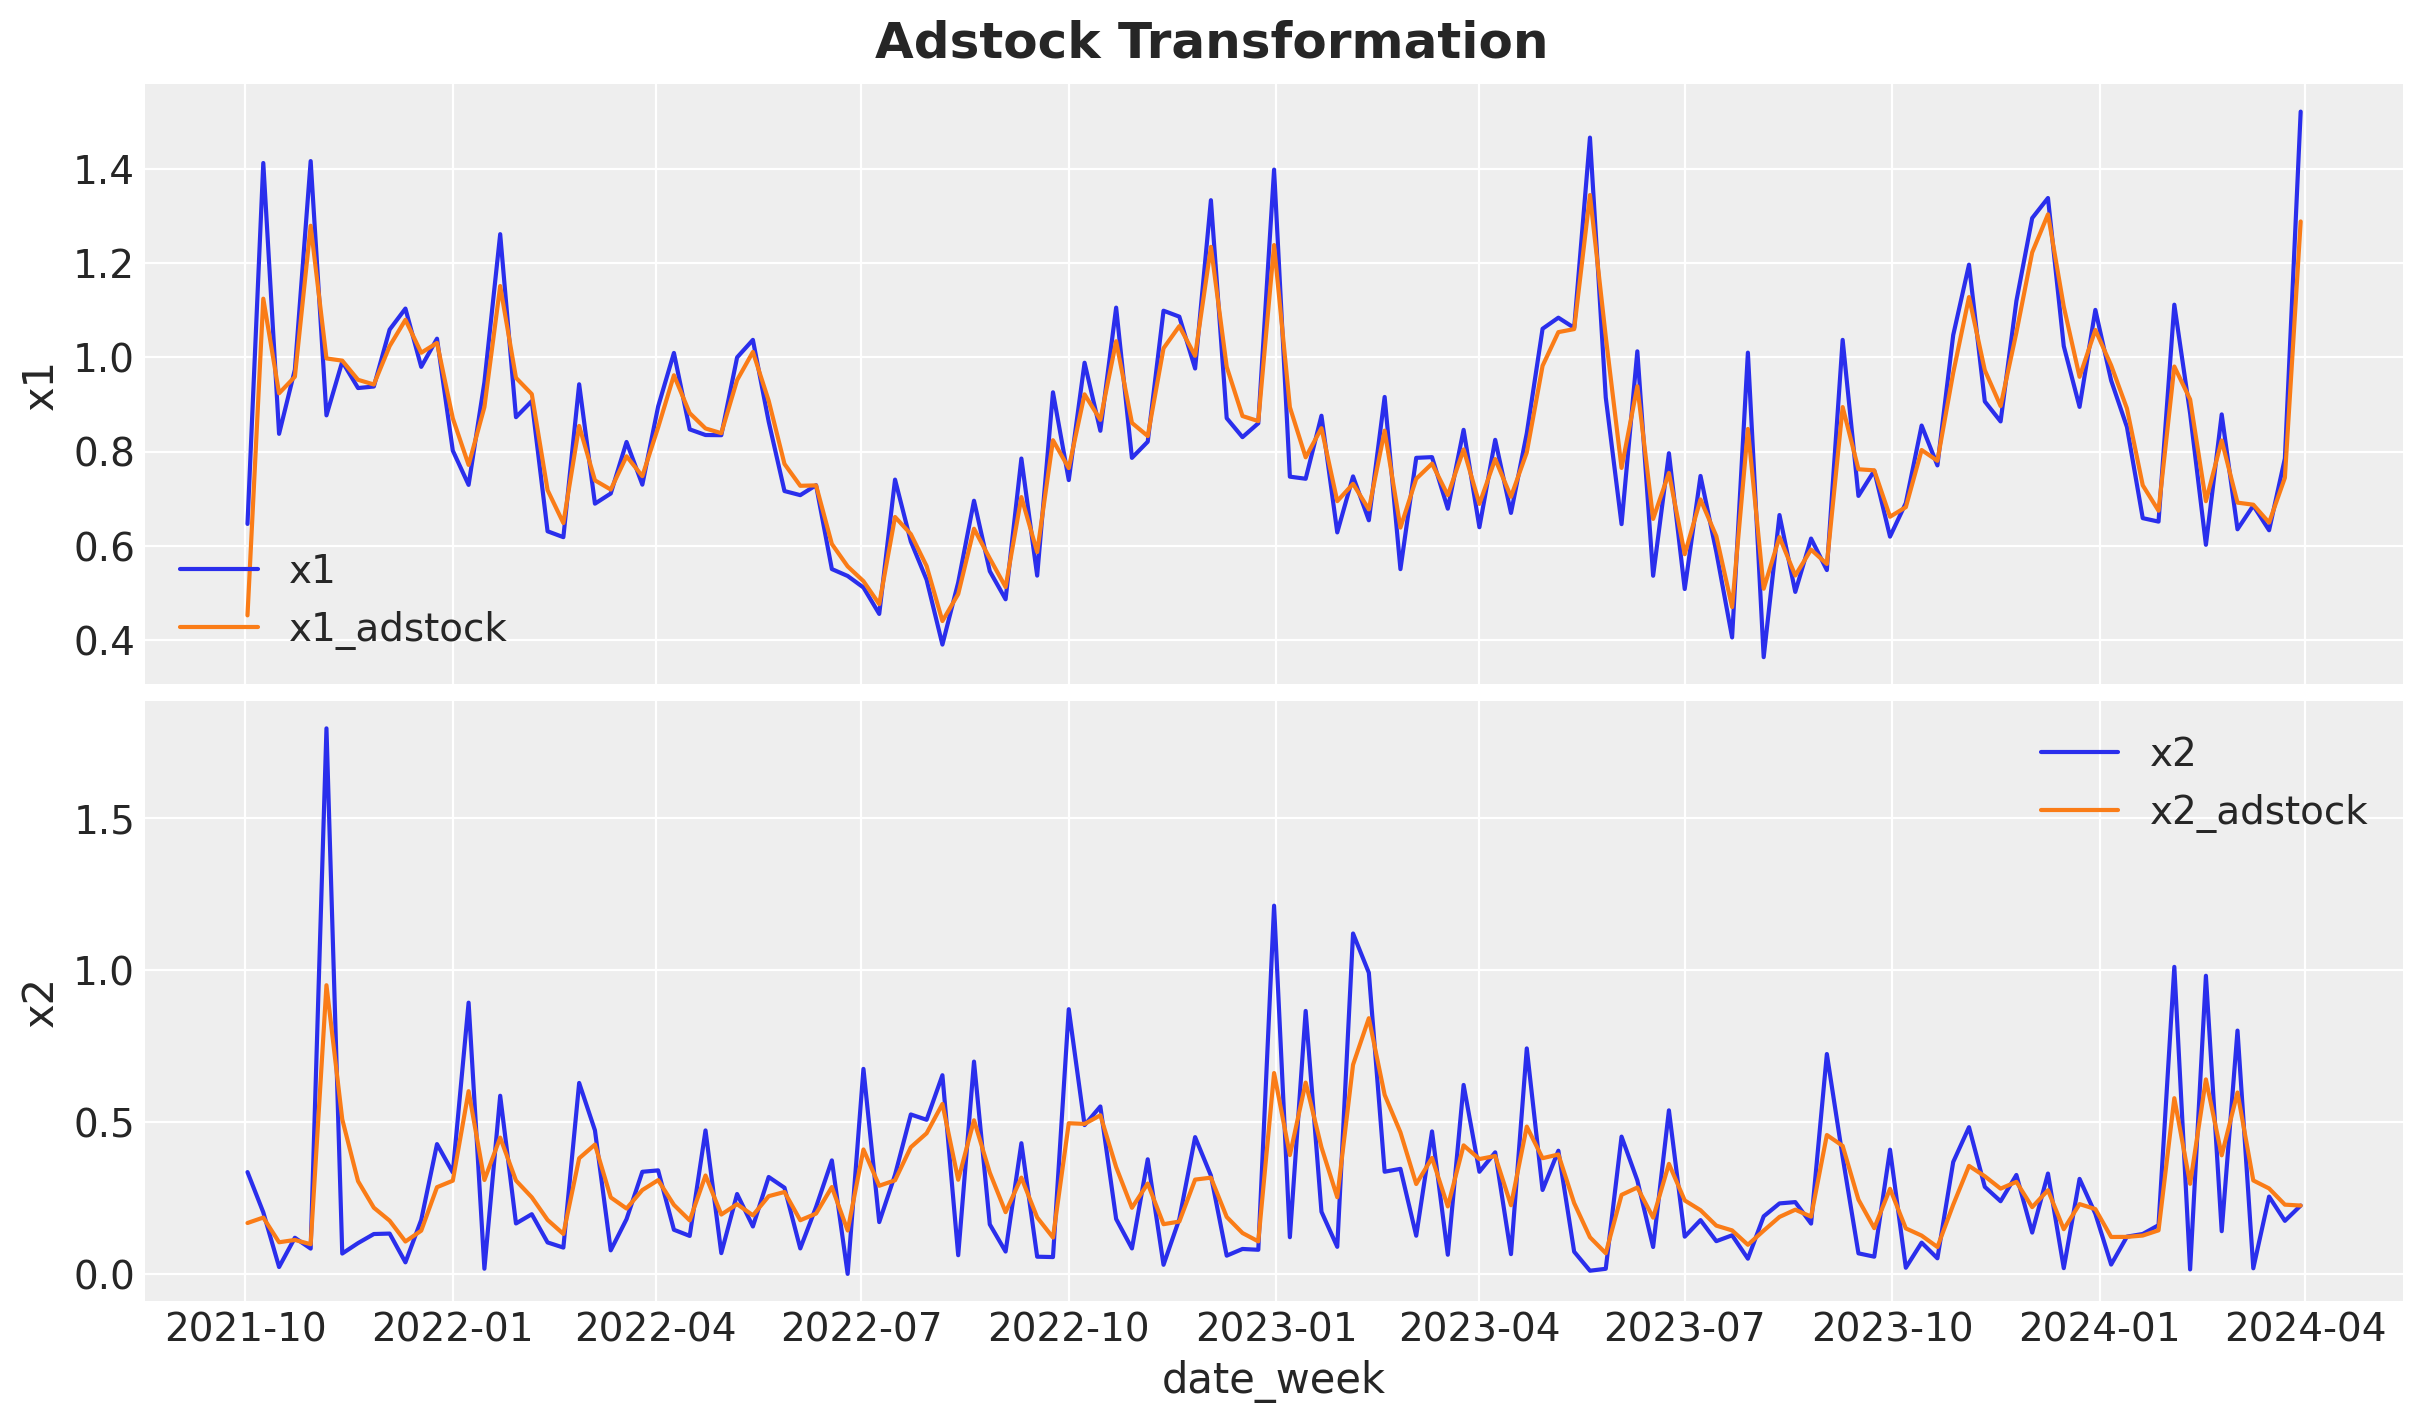

In [10]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=data_df, color="C0", label="x1", ax=ax[0])
sns.lineplot(
    x="date_week",
    y="x1_adstock",
    data=data_df,
    color="C1",
    label="x1_adstock",
    ax=ax[0],
)
sns.lineplot(x="date_week", y="x2", data=data_df, color="C0", label="x2", ax=ax[1])
sns.lineplot(
    x="date_week",
    y="x2_adstock",
    data=data_df,
    color="C1",
    label="x2_adstock",
    ax=ax[1],
)

fig.suptitle("Adstock Transformation", fontsize=18, fontweight="bold")

In [11]:
# apply saturation transformation
lam1: float = 1.0
lam2: float = 2.5

data_df["x1_adstock_saturated"] = logistic_saturation(
    x=data_df["x1_adstock"].to_numpy(), lam=lam1
).eval()

data_df["x2_adstock_saturated"] = logistic_saturation(
    x=data_df["x2_adstock"].to_numpy(), lam=lam2
).eval()

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_6815/4029364520.py:14: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


Text(0.5, 0.98, 'Media Costs Data - Transformed')

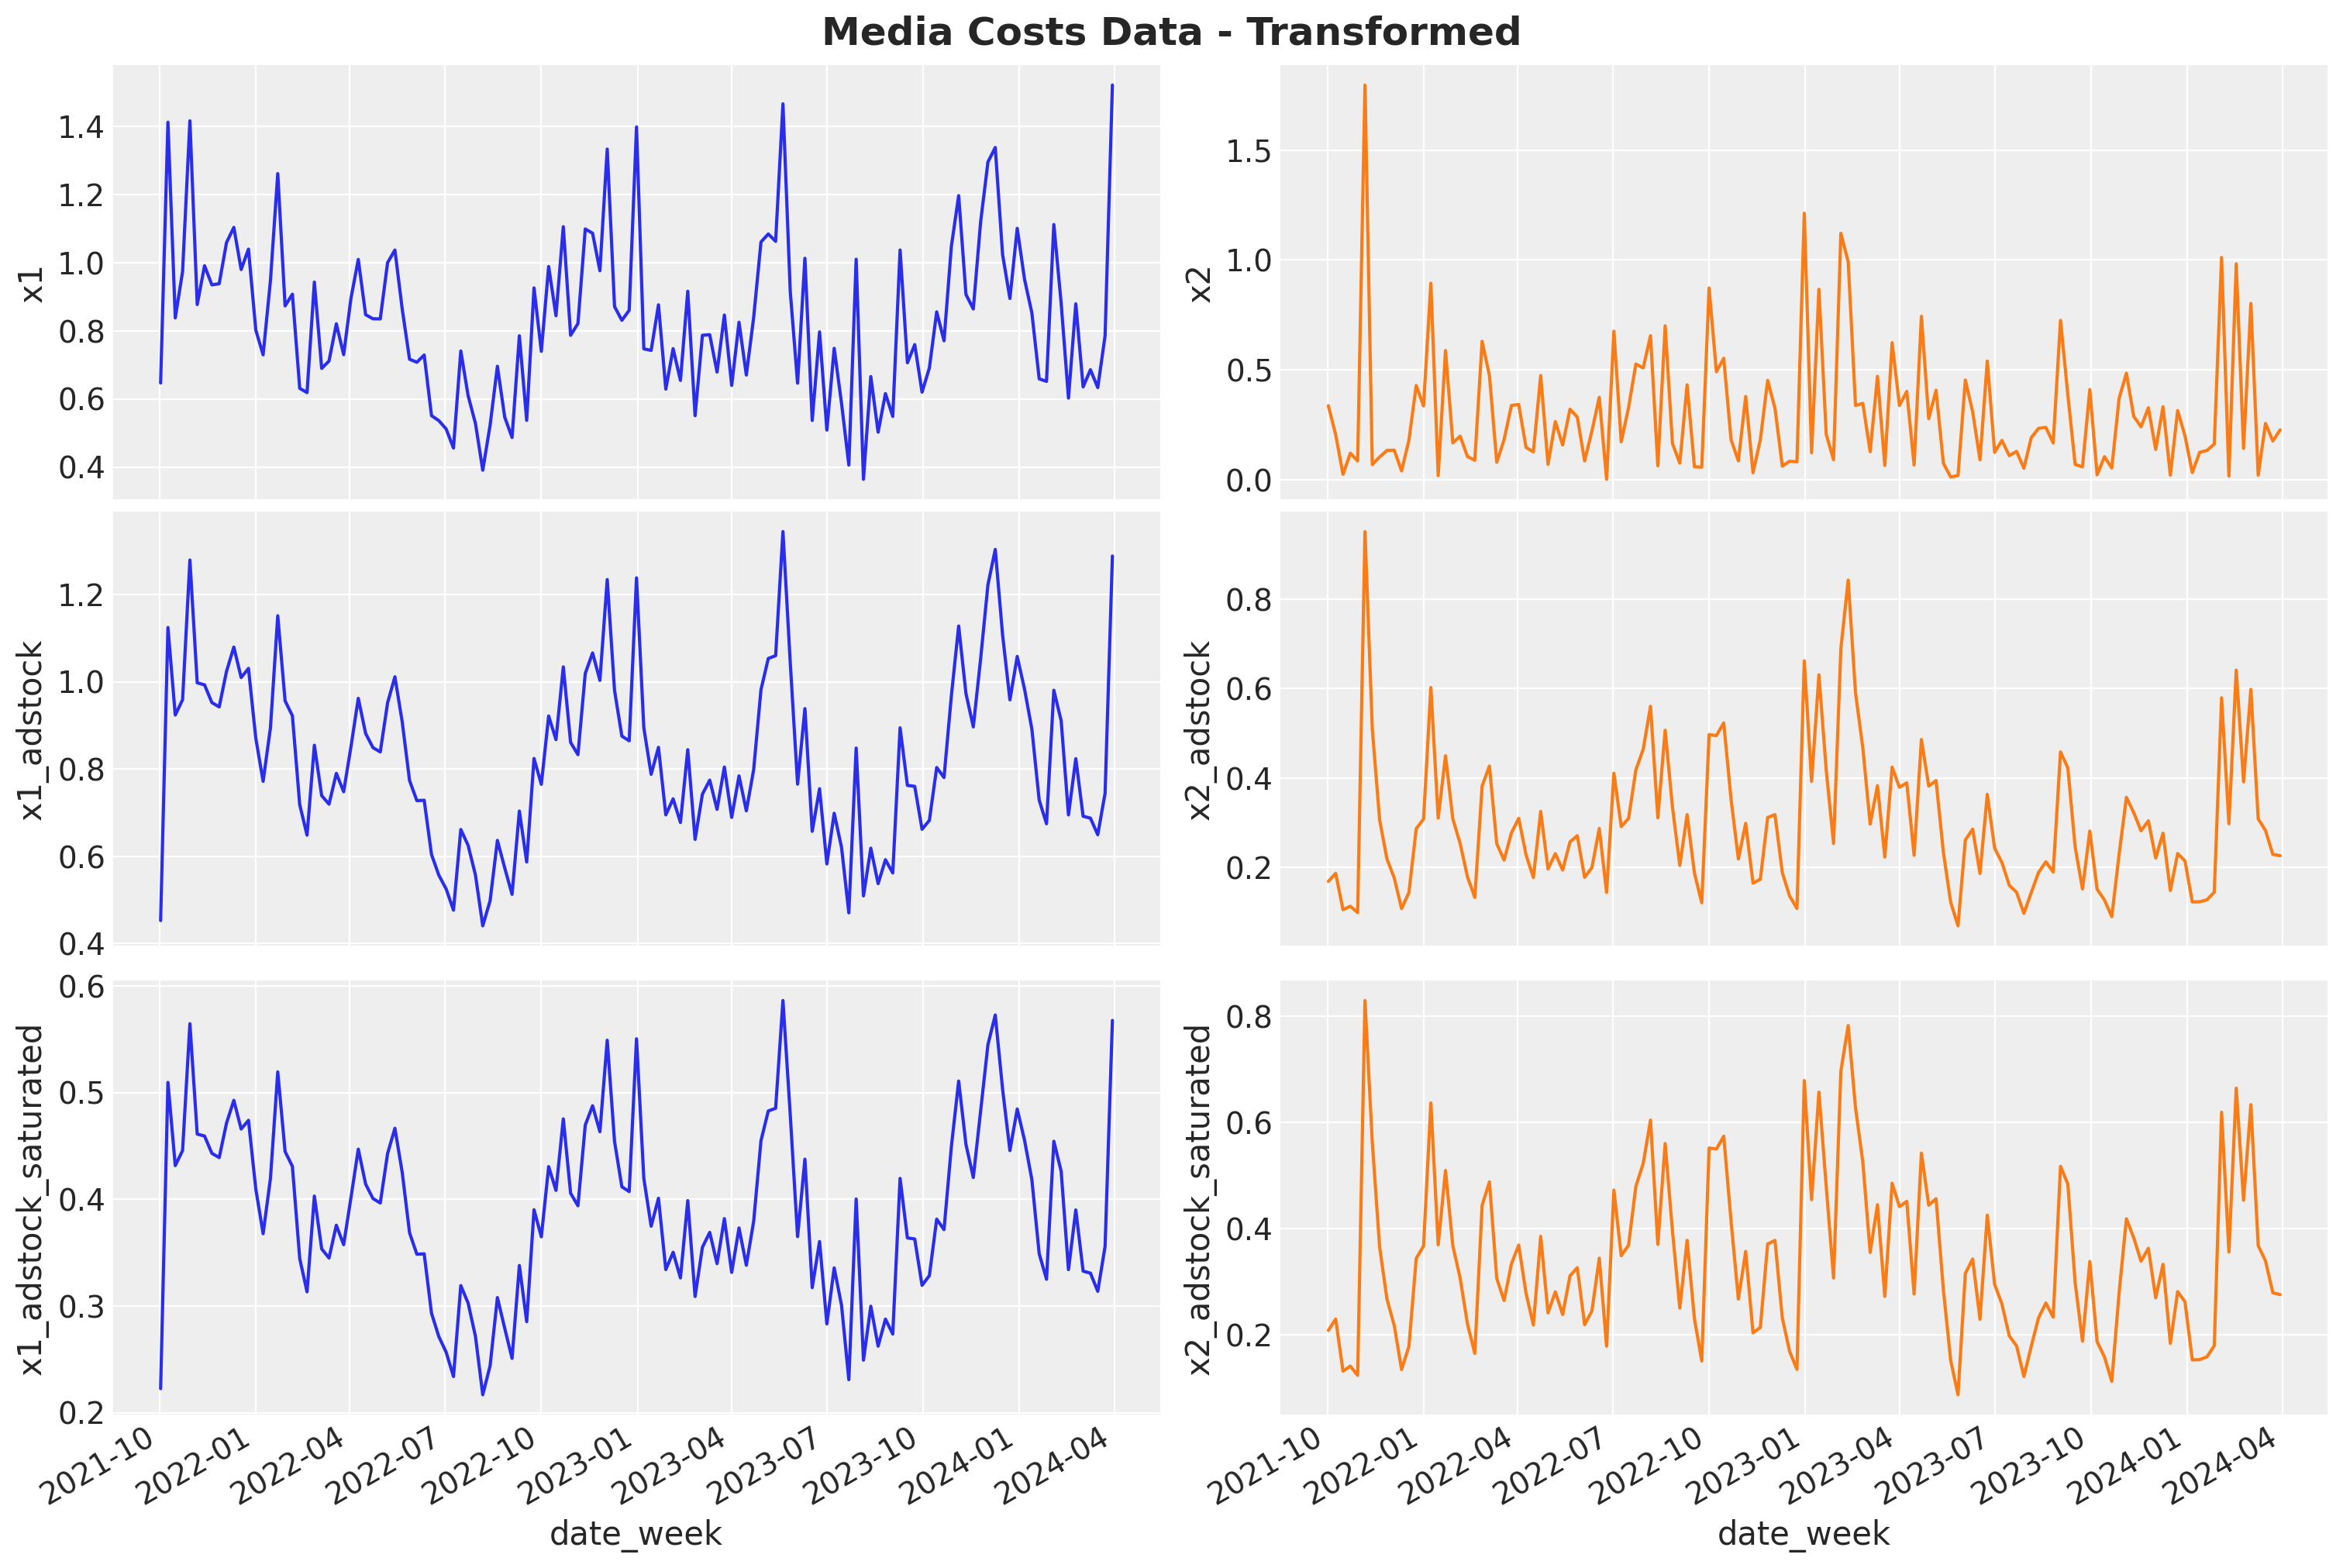

In [12]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(15, 10), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=data_df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=data_df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=data_df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=data_df, color="C1", ax=ax[1, 1])
sns.lineplot(
    x="date_week", y="x1_adstock_saturated", data=data_df, color="C0", ax=ax[2, 0]
)
sns.lineplot(
    x="date_week", y="x2_adstock_saturated", data=data_df, color="C1", ax=ax[2, 1]
)
fig.autofmt_xdate()
fig.suptitle("Media Costs Data - Transformed", fontsize=18, fontweight="bold")

In [13]:
beta1: float = 2.0
beta2: float = 1.5

data_df = data_df.eval(
    f"""
    x1_effect = {beta1} * x1_adstock_saturated
    x2_effect = {beta2} * x2_adstock_saturated
    y = 100 * (trend + seasonality + z + x1_effect + x2_effect + epsilon)
    """
)

Text(0.5, 0.98, 'Data Generating Process')

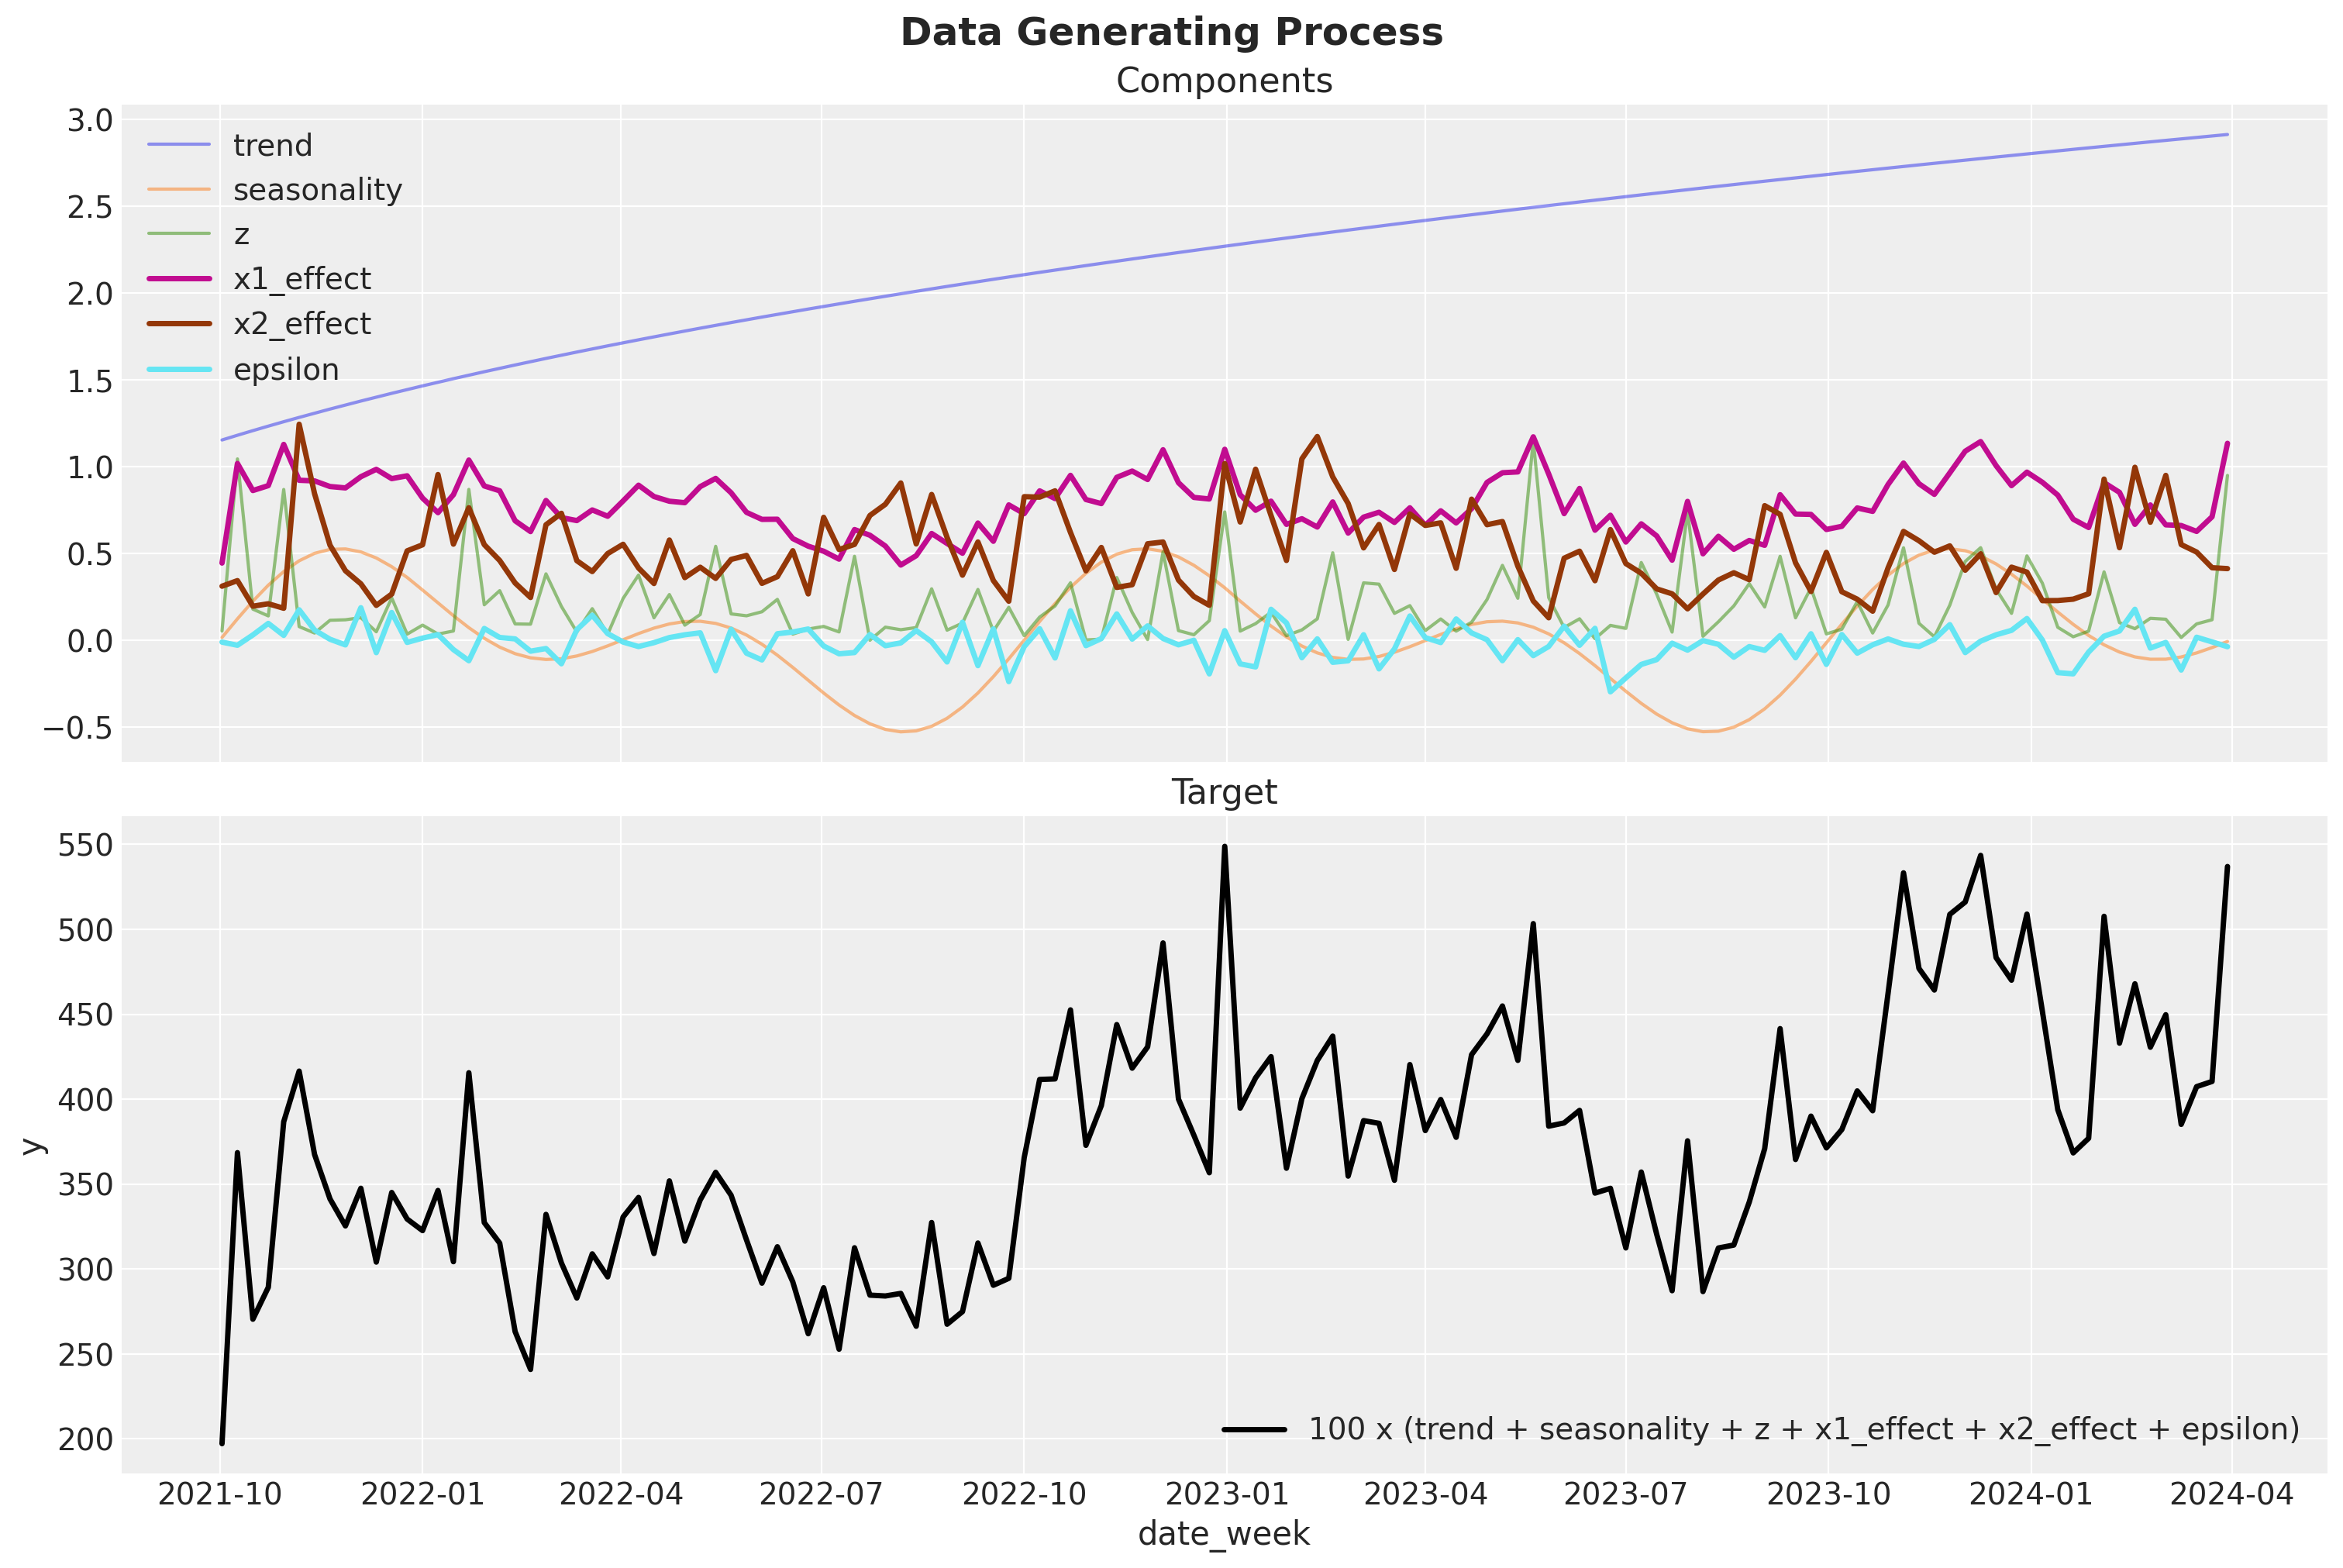

In [25]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15, 10),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="trend",
    color="C0",
    alpha=0.5,
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="seasonality",
    color="C1",
    alpha=0.5,
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(
    data=data_df, x="date_week", y="z", color="C2", alpha=0.5, label="z", ax=ax[0]
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="x1_effect",
    color="C3",
    linewidth=2.5,
    label="x1_effect",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="x2_effect",
    color="C4",
    linewidth=2.5,
    label="x2_effect",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="epsilon",
    color="C5",
    linewidth=2.5,
    label="epsilon",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set(title="Components", xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df,
    x="date_week",
    y="y",
    color="black",
    linewidth=2.5,
    label="100 x (trend + seasonality + z + x1_effect + x2_effect + epsilon)",
    ax=ax[1],
)
ax[1].legend(loc="lower right")
ax[1].set(title="Target")

fig.suptitle(t="Data Generating Process", fontsize=18, fontweight="bold")

In [17]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date_week             131 non-null    datetime64[ns]
 1   dayofyear             131 non-null    int32         
 2   trend                 131 non-null    float64       
 3   cs                    131 non-null    float64       
 4   cc                    131 non-null    float64       
 5   seasonality           131 non-null    float64       
 6   z                     131 non-null    float64       
 7   x1                    131 non-null    float64       
 8   x2                    131 non-null    float64       
 9   epsilon               131 non-null    float64       
 10  x1_adstock            131 non-null    float64       
 11  x2_adstock            131 non-null    float64       
 12  x1_adstock_saturated  131 non-null    float64       
 13  x2_adstock_saturated

### Data Preparation

In [22]:
columns_to_keep = [
    "date_week",
    "dayofyear",
    "z",
    "x1",
    "x2",
    "y",
]

model_df = data_df[columns_to_keep]

model_df.head()

,date_week,dayofyear,z,x1,x2,y
0,2021-10-02,275,0.053693,0.646554,0.336188,197.094468
1,2021-10-09,282,1.045243,1.411917,0.203931,368.498137
2,2021-10-16,289,0.179703,0.837610,0.024026,270.395147
3,2021-10-23,296,0.140496,0.973612,0.120257,289.185476
4,2021-10-30,303,0.869155,1.415985,0.084630,386.717105


In [36]:
date_week = model_df["date_week"]

target = "y"
targer_scaler = MaxAbsScaler()
target_scaled = targer_scaler.fit_transform(model_df[[target]])

channels = ["x1", "x2"]
channels_scaler = MaxAbsScaler()
channels_scaled = channels_scaler.fit_transform(model_df[channels])

controls = ["z"]
controls_scaler = MaxAbsScaler()
controls_scaled = controls_scaler.fit_transform(model_df[controls])

In [40]:
n_order = 5
periods = model_df["dayofyear"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

## Model Parametrization 1

In [ ]:
coords = {"date": date, "fourier_mode": np.arange(2 * n_order)}

In [ ]:
with pm.Model(coords=coords) as adstock_saturation_model:
    # --- data containers ---
    z_scaled_ = pm.MutableData(name="z_scaled", value=z_scaled, dims="date")

    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=4)
    ## trend
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=2)
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=2, dims="fourier_mode")
    ## adstock effect
    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    ## saturation effect
    lam = pm.Gamma(name="lam", alpha=3, beta=1)
    ## regressor
    b_z = pm.HalfNormal(name="b_z", sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- model parametrization ---
    trend = pm.Deterministic("trend", a + b_trend * t, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality", var=pm.math.dot(fourier_features, b_fourier), dims="date"
    )
    z_adstock = pm.Deterministic(
        name="z_adstock",
        var=geometric_adstock(x=z_scaled_, alpha=alpha, l_max=12),
        dims="date",
    )
    z_adstock_saturated = pm.Deterministic(
        name="z_adstock_saturated",
        var=logistic_saturation(x=z_adstock, lam=lam),
        dims="date",
    )
    z_effect = pm.Deterministic(
        name="z_effect", var=b_z * z_adstock_saturated, dims="date"
    )
    mu = pm.Deterministic(name="mu", var=trend + seasonality + z_effect, dims="date")

    # --- likelihood ---
    pm.StudentT(
        name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=y_scaled, dims="date"
    )

    # --- prior samples
    adstock_saturation_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(model=adstock_saturation_model)